Malware Type Mappings: {0: '180solutions', 1: 'Ako', 2: 'Benign', 3: 'CWS', 4: 'Conti', 5: 'Emotet', 6: 'Gator', 7: 'Maze', 8: 'Pysa', 9: 'Reconyc', 10: 'Refroso', 11: 'Scar', 12: 'Shade', 13: 'TIBS', 14: 'Transponder', 15: 'Zeus'}

Training Decision Tree...

=== Decision Tree Classification Report ===
              precision    recall  f1-score   support

           0       0.38      0.38      0.38       400
           1       0.34      0.33      0.34       400
           2       1.00      1.00      1.00      5860
           3       0.37      0.35      0.36       400
           4       0.39      0.38      0.39       398
           5       0.46      0.47      0.46       393
           6       0.58      0.61      0.60       440
           7       0.52      0.52      0.52       392
           8       0.36      0.38      0.37       343
           9       0.53      0.56      0.54       314
          10       0.70      0.65      0.67       400
          11       0.49      0.49      0.49    

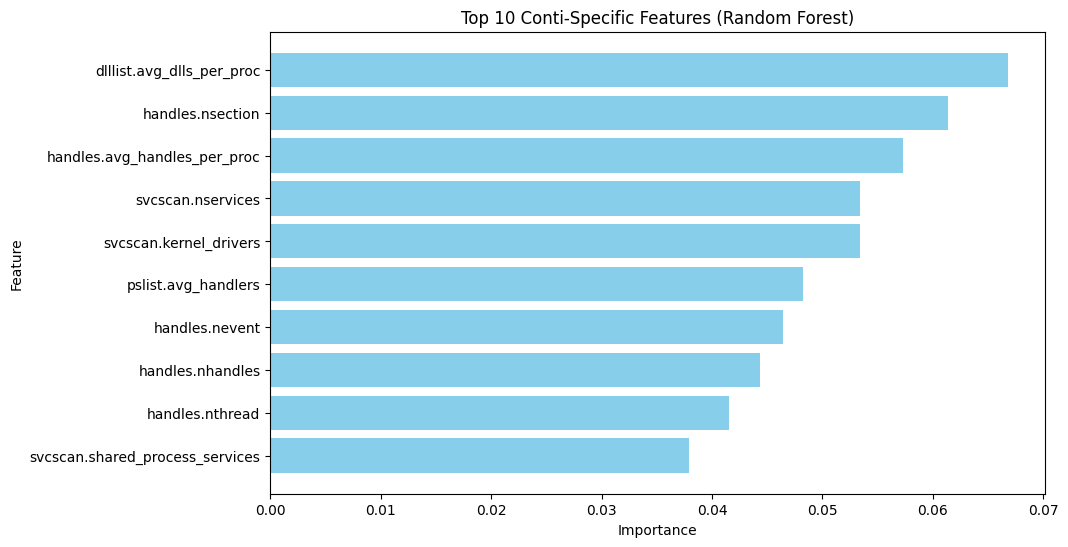


Final Model Performance Summary:
                     Accuracy  F1 Score  Precision    Recall  Training Time
Decision Tree        0.732338  0.732561   0.732959  0.732338           1.22
Random Forest        0.756058  0.754745   0.755409  0.756058          12.17
Logistic Regression  0.622184  0.616581   0.634257  0.622184          18.46
SVM (RBF Kernel)     0.618345  0.617746   0.681520  0.618345          98.34
XGBoost              0.759727  0.758314   0.758981  0.759727          21.55


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import time

# Load the dataset
df = pd.read_csv("data.csv")

# Extract Malware Type from `Category` Column
def extract_malware_type(category):
    return category.split("-")[1] if "-" in category else category

df["Malware_Type"] = df["Category"].apply(extract_malware_type)

# Drop `Category` column
df.drop(columns=["Category"], inplace=True)

# Encode Malware Type as Labels
le = LabelEncoder()
df["Malware_Type"] = le.fit_transform(df["Malware_Type"])

# Print the mapping of malware types
malware_mapping = {index: label for index, label in enumerate(le.classes_)}
print("Malware Type Mappings:", malware_mapping)

# Split Features (X) and Target (y)
y = df["Malware_Type"]
X = df.drop(columns=["Malware_Type", "Class"])

# Ensure all columns in `X` are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Check for missing values and fill with median using SimpleImputer
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# Convert back to DataFrame
X = pd.DataFrame(X_imputed, columns=X.columns)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Multiple Classifiers
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=42),
    "SVM (RBF Kernel)": SVC(kernel="rbf", random_state=42),
    "XGBoost": RandomForestClassifier(n_estimators=200, random_state=42)
}

# Store results
results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    start_time = time.time()

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    end_time = time.time()
    training_time = round(end_time - start_time, 2)

    print(f"\n=== {model_name} Classification Report ===")
    print(classification_report(y_test, y_pred))

    results[model_name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred, average='weighted'),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "Training Time": training_time
    }

    print(f"\nTraining time for {model_name}: {training_time} seconds")

# Extract Conti-Specific Feature Importance

# Identify the index of Conti in the encoded labels
conti_class_index = list(malware_mapping.values()).index("Conti")

# Get the trained Random Forest model
rf_model = models["Random Forest"]

# Extract feature importances from Random Forest
feature_importances = rf_model.feature_importances_

# Sort and get the top 10 important features
sorted_indices = np.argsort(feature_importances)[::-1]  # Sort descending
top_features = sorted_indices[:10]

# Create a DataFrame for better visualization
conti_feature_df = pd.DataFrame({
    "Feature": X.columns[top_features],
    "Importance": feature_importances[top_features]
})

# Display the top features
print("\nTop 10 Conti-Specific Features (Random Forest):")
print(conti_feature_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(conti_feature_df["Feature"], conti_feature_df["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Conti-Specific Features (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

# Print Final Summary
results_df = pd.DataFrame.from_dict(results, orient="index")
print("\nFinal Model Performance Summary:")
print(results_df)

# 

## Generate Adversarial Examples

#### Import Packages

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

#### Generate FGSM Attack 

In [5]:
def decision_tree_attack(model, X, epsilon=0.05):
    """
    Generates adversarial examples by adding small perturbations to decision boundaries.
    
    model: trained tree-based classifier
    X: input features (NumPy array)
    epsilon: perturbation magnitude
    """
    X_adv = X.copy()
    
    # Generate small random noise
    noise = np.random.uniform(-epsilon, epsilon, X.shape)
    
    # Apply noise
    X_adv += noise
    
    return np.clip(X_adv, 0, 1)  

# Test with a smaller epsilon
X_adv = decision_tree_attack(models["Random Forest"], X_test_scaled, epsilon=0.01)

# Evaluate again
y_adv_pred = models["Random Forest"].predict(X_adv)

adv_results = {
    "Accuracy": accuracy_score(y_test, y_adv_pred),
    "F1 Score": f1_score(y_test, y_adv_pred, average='weighted'),
    "Precision": precision_score(y_test, y_adv_pred, average='weighted', zero_division=1),
    "Recall": recall_score(y_test, y_adv_pred, average='weighted'),
}

print("\n=== Model Performance After Tuned Randomized Perturbation Attack (epsilon=0.01) ===")
print(adv_results)


=== Model Performance After Tuned Randomized Perturbation Attack (epsilon=0.01) ===
{'Accuracy': 0.5006825938566553, 'F1 Score': 0.33482798885009285, 'Precision': 0.7501707650273223, 'Recall': 0.5006825938566553}


In [6]:
print("\n=== Detailed Classification Report After Tuned Attack ===")
print(classification_report(y_test, y_adv_pred, target_names=le.classes_))


=== Detailed Classification Report After Tuned Attack ===
              precision    recall  f1-score   support

180solutions       0.00      0.00      0.00       400
         Ako       0.00      0.00      0.00       400
      Benign       0.50      1.00      0.67      5860
         CWS       0.00      0.00      0.00       400
       Conti       0.00      0.00      0.00       398
      Emotet       0.00      0.00      0.00       393
       Gator       0.00      0.00      0.00       440
        Maze       0.00      0.00      0.00       392
        Pysa       0.00      0.00      0.00       343
     Reconyc       0.00      0.00      0.00       314
     Refroso       0.00      0.00      0.00       400
        Scar       0.00      0.00      0.00       400
       Shade       0.00      0.00      0.00       426
        TIBS       0.00      0.00      0.00       282
 Transponder       1.00      0.02      0.03       482
        Zeus       0.00      0.00      0.00       390

    accuracy         

c:\Users\adamp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\adamp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\adamp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

## Adversarial Training

In [7]:
# Generate adversarial examples for training
X_train_adv = decision_tree_attack(models["Random Forest"], X_train_scaled, epsilon=0.01)

# Combine clean and adversarial data
X_train_augmented = np.vstack((X_train_scaled, X_train_adv))
y_train_augmented = np.hstack((y_train, y_train)) 

# Train a robust model
robust_rf = RandomForestClassifier(n_estimators=200, random_state=42)
robust_rf.fit(X_train_augmented, y_train_augmented)

# Evaluate robustness on adversarial test examples
y_adv_pred_robust = robust_rf.predict(X_adv)

# Compute new evaluation metrics
robust_results = {
    "Accuracy": accuracy_score(y_test, y_adv_pred_robust),
    "F1 Score": f1_score(y_test, y_adv_pred_robust, average='weighted'),
    "Precision": precision_score(y_test, y_adv_pred_robust, average='weighted', zero_division=1),
    "Recall": recall_score(y_test, y_adv_pred_robust, average='weighted'),
}

print("\n=== Model Performance After Adversarial Training ===")
print(robust_results)



=== Model Performance After Adversarial Training ===
{'Accuracy': 0.6283276450511945, 'F1 Score': 0.6278814774941103, 'Precision': 0.6319678319814833, 'Recall': 0.6283276450511945}


In [14]:
results_comparison = pd.DataFrame({
    "Original": results["Random Forest"],
    "After Attack": adv_results,
    "After Adversarial Training": robust_results
})

from IPython.display import display
display(results_comparison)


,Original,After Attack,After Adversarial Training
Accuracy,0.756058,0.500597,0.628413
F1 Score,0.754745,0.334644,0.627840
Precision,0.755409,0.750149,0.631338
Recall,0.756058,0.500597,0.628413
Training Time,11.800000,NaN,NaN
